<img src='logo.png'>

ref: https://www.kaggle.com/c/titanic

타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings(action='ignore') #경고창 없애기


##  1. Data load
데이터셋 확인 - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.

In [2]:
os.getcwd()

'C:\\AI\\Python 3.8\\venv\\comp\\titanic'

In [3]:
train=pd.read_csv("./dataset/train.csv")

In [4]:
print(train.shape)
print(train.info())
train.head()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


sibSp: 함께 탑승한 부모, 아이의 수 </br>
parch: 함께 탑승한 부모, 아이의 수

## 2. EDA : 사전 데이터 탐색

탐색적 데이터 분석(exploratory data analysis) - 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.

### Survived: Target Feature
target label 이 어떤 distribution 을 가지고 있는 지 확인해봐야 합니다.

0    549
1    342
Name: Survived, dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


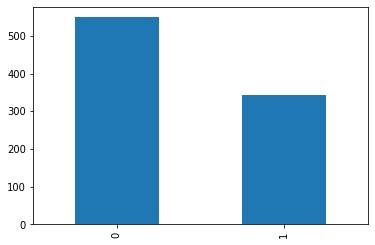

In [5]:
print(train['Survived'].value_counts(),train['Survived'].value_counts().plot(kind='bar'))

<AxesSubplot:ylabel='Survived'>

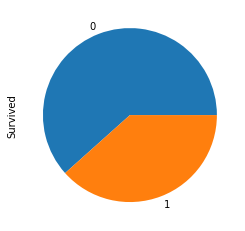

In [6]:
train['Survived'].value_counts().plot(kind='pie')

target label 의 분포가 제법 균일(balanced)합니다. 불균일한 경우, 예를 들어서 100중 1이 99, 0이 1개인 경우에는 만약 모델이 모든것을 1이라 해도 정확도가 99%가 나오게 됩니다. 0을 찾는 문제라면 이 모델은 원하는 결과를 줄 수 없게 됩니다. 지금 문제에서는 그렇지 않으니 계속 진행하겠습니다.

3    491
1    216
2    184
Name: Pclass, dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


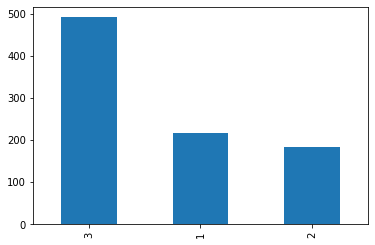

In [7]:
print(train['Pclass'].value_counts(),train['Pclass'].value_counts().plot(kind='bar'))

male      577
female    314
Name: Sex, dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


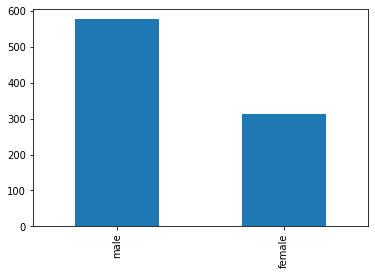

In [8]:
print(train['Sex'].value_counts(),train['Sex'].value_counts().plot(kind='bar'))

S    644
C    168
Q     77
Name: Embarked, dtype: int64 AxesSubplot(0.125,0.125;0.775x0.755)


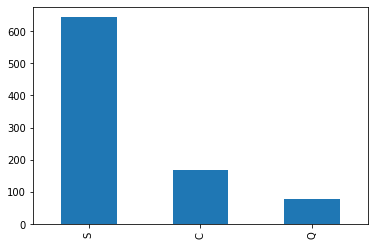

In [9]:
print(train['Embarked'].value_counts(),train['Embarked'].value_counts().plot(kind='bar'))

In [10]:
train['name_title']=train['Name'].str.extract('([a-zA-Z]+)[.]',expand=False)
train['name_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

#### 중복 의미의 호칭 정리

In [11]:
#Mme MLLe ->Mrs
# Ms Lady -> Miss

In [12]:
train['name_title'].replace('Mme','Mrs',inplace=True)
train['name_title'].replace('MLLe','Mrs',inplace=True)
train['name_title'].replace('Ms','Miss',inplace=True)
train['name_title'].replace('Lady','Miss',inplace=True)
train['name_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Major', 'Sir',
       'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer'], dtype=object)

In [13]:
train[['name_title','Age']].value_counts()
pd.crosstab(train['name_title'],train['Age'].isna().sum()).head()

col_0,177
name_title,
Capt,1
Col,2
Countess,1
Don,1
Dr,7


#### 그룹별 평균 나이

- groupby 값을 이용해 fillna()할 경우 transform( ) 사용!
- train['Age'].apply( ) = train['Age'].transfrom( ) 
- train.groupby('pclass')['Age'].apply( ) !=train.groupby('pclass')['Age'].transform( ) 
- 그냥 쓸 때는 같은 결과 but 그룹핑 했을 때는 다른 결과가 나옴! 

In [14]:
train['Age']=train['Age'].fillna(train.groupby(by='name_title')['Age'].transform('mean'),)
train['Age'].isnull().sum()

0

In [15]:
train.groupby(by='name_title')['Age'].mean()

name_title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Major       48.500000
Master       4.574167
Miss        21.993243
Mlle        24.000000
Mr          32.368090
Mrs         35.788991
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64

In [16]:
train['Age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

#### 호칭 > 수치 변환 (인코딩)

In [17]:
#pd.crosstab(train['name_title'],train['Survived']).index
#train['name_title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer','Sir'],'Miss',inplace=True)

In [18]:
title_dict = {'Major':0, 'Master':1,'Miss':2, 'Mr':3, 'Mrs':4, 'Rev':5,
              'Capt':6, 'Col':6, 'Countess':6, 'Don':6, 'Dr':6, 'Jonkheer':6, 'Sir':6 }

train['name_title']=train['name_title'].map(title_dict)
train['name_title']

0      3.0
1      4.0
2      2.0
3      4.0
4      3.0
      ... 
886    5.0
887    2.0
888    2.0
889    3.0
890    3.0
Name: name_title, Length: 891, dtype: float64

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,name_title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,4.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,4.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3.0


 대체로 레코드 수 = unique 수 이다. </br>
결측치와 unique값을 확인해본다.

In [20]:
print(train.isnull().sum()[train.isna().sum() >0])
print("---"*10)
print(train.nunique()[train.nunique()  >= 650])

Cabin         687
Embarked        2
name_title      2
dtype: int64
------------------------------
PassengerId    891
Name           891
Ticket         681
dtype: int64


ticket이 survived와 관련있는지 확인해보았으나, 무의미하므로 컬럼을 삭제한다.

In [21]:
train[['Ticket', 'Survived']].value_counts().sort_values(ascending=False)

Ticket             Survived
CA. 2343           0           7
347082             0           7
347088             0           6
CA 2144            0           6
3101295            0           6
                              ..
STON/O 2. 3101280  0           1
PC 17604           1           1
PC 17603           1           1
A.5. 11206         0           1
WE/P 5735          1           1
Length: 730, dtype: int64

['PassengerId','Name','Ticket'] 는 분석하기에 적합하지 않은 컬럼이므로 삭제한다.

In [22]:
train.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,name_title
0,0,3,male,22.0,1,0,7.2500,NaN,S,3.0
1,1,1,female,38.0,1,0,71.2833,C85,C,4.0
2,1,3,female,26.0,0,0,7.9250,NaN,S,2.0
3,1,1,female,35.0,1,0,53.1000,C123,S,4.0
4,0,3,male,35.0,0,0,8.0500,NaN,S,3.0


## 3. Feature Engineering & Preprocessing: 피쳐 가공

모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 합니다. </br>
one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.
Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

### 3-1. 결측치 처리
null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.

Null data: Embarked,Age,Cabin

### Embarked: 최빈값으로 채우기
최빈값(mode): 가장 빈번하게 관찰/측정되는 값

In [23]:
#최빈값으로 결측치 fillna()
mode_var = train['Embarked'].mode().values[0]
train['Embarked']=train['Embarked'].fillna(mode_var) #'S'
train['Embarked'].isnull().sum()

0

#### crosstab:범주형 변수를 기준으로 개수 파악이나 수치형 데이터를 넣어 계산할 때 사용

In [24]:
pd.crosstab(train['Embarked'],train['Survived'])

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,219


### Age : Name 호칭을 사용해 그들의 평균 나이로 채우기

In [25]:
avg_age = int(train['Age'].mean())
train['Age']=train['Age'].fillna(avg_age).astype('int') # column casting
train['Age'].isnull().sum()

0

### Cabin : 공백처리
* 점수를 봐가며 삭제 여부 결정
* Pclass=1 인 승객 대부분이 Cabin을 가지고 있다
* 삭제여부 미정 : Pclass 하나만 봐도 된다
* A~T 세분화되어 있어서  C1 , C2 , C3

In [26]:
#결측치 공백처리
train['Cabin']=train['Cabin'].fillna('')
train['Cabin'].unique()

array(['', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'E31',
       'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69', 'D47',
       'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32', 'B4',
       'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       

In [27]:
train[['Cabin','Survived']].value_counts()

Cabin    Survived
         0           481
         1           206
B96 B98  1             4
F33      1             3
E101     1             3
                    ... 
C111     0             1
C118     0             1
C123     0             1
         1             1
T        0             1
Length: 165, dtype: int64

In [28]:
pd.crosstab(index=train['Cabin'],columns = train['Survived'])

Survived,0,1
Cabin,,
,481,206
A10,1,0
A14,1,0
A16,0,1
A19,1,0
...,...,...
F33,0,3
F38,1,0
F4,0,2


In [29]:
pd.crosstab(index=train['Cabin'],columns = train['Pclass'])

Pclass,1,2,3
Cabin,,,
,40,168,479
A10,1,0,0
A14,1,0,0
A16,1,0,0
A19,1,0,0
...,...,...,...
F33,0,3,0
F38,0,0,1
F4,0,2,0


In [30]:
train.info() #결측처리 완료

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    int32  
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Cabin       891 non-null    object 
 8   Embarked    891 non-null    object 
 9   name_title  889 non-null    float64
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 66.3+ KB


### 3-2. object을 numeric(수치)타입으로 변경

- map: 여러 개의 데이터를 한 번에 다른 형태로 변환하기 위해서 사용
-lambda 
-replace
-get_dummies

### object타입 컬럼 추출

In [31]:
col_list=train.select_dtypes(include='object').columns.tolist()
print(col_list)

['Sex', 'Cabin', 'Embarked']


### df['col'].astype('category')사용해 numeric으로 변경

In [32]:
train['Cabin']= train['Cabin'].astype('category').cat.codes #범주형으로 변환
train['Sex2'] = train['Sex'].astype('category').cat.codes
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,name_title,Sex2
0,0,3,male,22,1,0,7.2500,0,S,3.0,1
1,1,1,female,38,1,0,71.2833,82,C,4.0,0
2,1,3,female,26,0,0,7.9250,0,S,2.0,0
3,1,1,female,35,1,0,53.1000,56,S,4.0,0
4,0,3,male,35,0,0,8.0500,0,S,3.0,1


### pd.get_dummies() 
주로 마지막에 쓴다
* 결측처리  + LabelEncoder() + OneHotEncoder()

In [33]:
train = pd.get_dummies(train, columns=['Sex'])
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,name_title,Sex2,Sex_female,Sex_male
0,0,3,22,1,0,7.2500,0,S,3.0,1,0,1
1,1,1,38,1,0,71.2833,82,C,4.0,0,1,0
2,1,3,26,0,0,7.9250,0,S,2.0,0,1,0
3,1,1,35,1,0,53.1000,56,S,4.0,0,1,0
4,0,3,35,0,0,8.0500,0,S,3.0,1,0,1


### df.replace( ) 
df['col'].replace(['a','b'] , [1,2] , inplace=True)

In [34]:
train['Embarked'].replace(['S','C','Q'],[1,2,3],inplace=True) #replace(old,new)
train['Embarked'].value_counts()

1    646
2    168
3     77
Name: Embarked, dtype: int64

### df.apply(lambda)

In [35]:
#train['Sex3']=train['Sex'].apply(lambda x: 1 if x=='male' else 0)
#train[['Sex3','Sex']]
#train.drop(['Sex3'],axis=1,inplace=True)
#res = 0
#if x == 'male':
#    res =1
#else:
#    res=0

### 3-3 feature가공: 불필요한 컬럼 모두 삭제

In [36]:
#train = train.drop(['Sex_female','Sex_male'], axis=1)

In [37]:
#train = train.rename(columns={"Sex2":"Sex"}) #컬럼명 바꾸기

### name_title fillna, astype

In [38]:
train['name_title']=train['name_title'].fillna(train['name_title'].mean())

In [39]:
train['name_title']=train['name_title'].astype('int')

### 3-4 상관분석: feature별 영향도 분석
- 상관도가 높다 => 두 feature가 유사한 특징을 갖는다.
이에 따라 다중공선성이 나타난다.

±0.9이상                : 매우 높은 상관관계 → 다중공선성 문제

±0.7이상 ~ ±0.9미만  : 높은 상관관계

±0.4이상 ~ ±0.7미만  : 다소 높은 상관관계 → 0.7미만이면 다중공선성 문제에서 안전합니다.

±0.2이상 ~ ±0.4미만  : 낮은 상관관계

±0.2미만               : 상관관계가 거의 없음

(상관관계계수의 최댓값은 1이고 최솟값은 -1입니다. 상관관계계수가 1이라는 것은 그 둘이 같다는 것입니다.)


In [40]:
import seaborn as sns 

<AxesSubplot:>

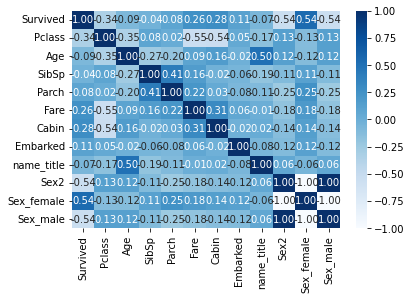

In [41]:
#히트맵은 주로 seaborn으로 그린다
sns.heatmap(train.corr(),cmap='Blues',annot=True,fmt=".2f")

### 3-4.1 Family: sibsp,parch 파생변수 추가
- Family = sibsp(형제)+ parch(부모자식)+1


alone과 family의 상관도가 높은 관계로 만들지 않기로 결정
- train['alone'] = sibsp(형제)+ parch(부모자식)==0 :오히려 정확도가 낮아짐
- sibsp(형제)+ parch(부모자식) drop

In [42]:
#컬럼 간 연산 가능
train['Family']= train['SibSp']+train['Parch']+1
#train['alone']= (train['SibSp']==0) & (train['Parch']==0)
#train['alone']=train['alone'].astype('int')
#train.drop(['SibSp','Parch','alone'],axis=1)

방법2) lambda 사용

In [43]:
#컬럼 1개에만 lambda 적용하는 경우
# train['Age']=train['Age'].apply(lambda x: 1 if x==20 else 0)

#프레임 통째(컬럼 여러 개)로 lambda 적용하는 경우 axis=1 축 추가!!
#train['alone']= train.apply(lambda x: 1 if x['SibSp']+ x['Parch']==0 else 0,axis=1)

### 3-4.2 Fare 구간화 (Binning)
연속형 변수 값을 범주형으로 변환!

In [44]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:>

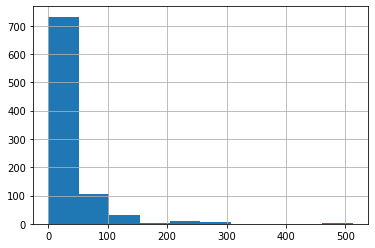

In [45]:
train['Fare'].hist()

<AxesSubplot:xlabel='Fare', ylabel='Count'>

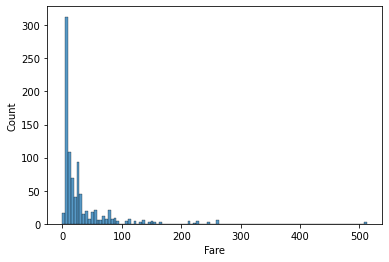

In [46]:
sns.histplot(data=train,x='Fare')

#### 방법 1) if~, lambda

In [47]:
def fare_binning(x):
    res=0 ## 꼭 해주기!
    if 0 <=  x <=7.91:
        res= 0
    elif 7.92  <=  x <=14.45:
        res= 1
    elif 14.46 <=  x <=31.00:
        res= 2
    elif 32.00 <=  x <=100.00:
        res=3
    elif 100.00 <=  x <= 200.00:
        res= 4
    elif 200.00 <=  x <= 300.00:
        res= 5
    elif 300.00 <=  x :
        res= 6
    return res ## 꼭 해주기!
#fare_binning(60)

train['Fare_binning'] =train['Fare'].apply(lambda x : fare_binning(x) )

#### 방법 2) train.loc[조건,컬럼] = 값

In [48]:
# train.loc[train['Fare']<=7.91,'Fare_binning'] = 0
# train.loc[(train['Fare']<=7.91)&('train['Fare']<=14.45)] = 1

#### 방법 3) cut( ), qcut( ) 추천
- cut(df,bins=n,labels=[ ]): 일정한 간격으로 동일하게 n등분 
- qcut(df, q=n ,labels=[ ]): 일정 개수로 등분
- bins의 개수는 labels의 개수보다 하나 더 많다

In [49]:
# #연습
# #train['Fare_binning']=pd.cut(x=train['Fare'],bins=3,labels=['a','b','c'])
# train['Fare_binning']=pd.qcut(x=train['Fare'],q=3,labels=['a','b','c'])
# train[['Fare_binning']].value_counts()

In [50]:
# # 연습, 0~7까지, 7~30까지, 30~550까지 bins를 구간화 가능!
# train['Fare_binning']=pd.cut(x=train['Fare'],bins=[0,7,30,550],labels=['a','b','c'])
# train[['Fare_binning']].value_counts()

In [51]:
#train.drop(['Fare'],axis=1,inplace=True)

#### 나이 구간화

In [52]:
train['Age'].describe()

count    891.000000
mean      29.638608
std       13.293812
min        0.000000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

<AxesSubplot:xlabel='Age', ylabel='Count'>

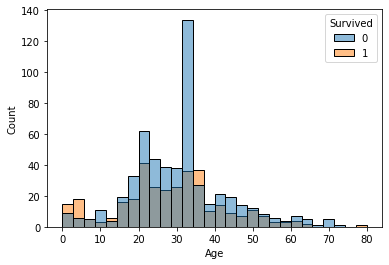

In [53]:
sns.histplot(data=train,x='Age',hue='Survived')

In [54]:
train['age_binning']=pd.cut(x=train['Age'],bins=[-1.0,12,18,22,27,33,40,66,100],labels=[1,2,3,4,5,6,7,8])
#train.drop(['Age','Fare'],axis=1,inplace=True)
#train['age_binning'].astype('int') #범주형으로 바뀌기 때문에 astype 해준다

## 4. 모델학습 및 평가

1. 지도학습: Supervisied learning - 분류, 회귀, 의사결정나무 등등 </br>
2. 비지도학습: Unsupervised learning - 군집 등등 

### 4-1. train과 test 데이터 분리

In [55]:
X = train.drop(['Survived'],axis=1) 
#X = train[train.columns.difference(['Survived'])] 
y = train['Survived'] 

In [56]:
# 시계열 데이터일 때는 shuffle = False
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(712, 14) (179, 14) (712,) (179,)


### 4-2. 모델 선정 & 학습 & 예측 & 평가

랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다.

In [57]:
#다중 클래스 분류에서는 average = 'macro' 옵션을 사용한다. 
def my_fun(y_test,y_vld):
    report = classification_report(y_test,y_vld)
    print(report)
    #[None,'micro','macro','weighted']
    acc = accuracy_score(y_test,y_vld)
    precision = precision_score(y_test,y_vld,average = 'macro') #일반적으로 macro쓴다.
    recall = recall_score(y_test,y_vld,average = 'macro')
    f1 = f1_score(y_test,y_vld,average = 'macro')
    print(f"정확도 {acc:.4f} 정밀도 {precision:.4f} 재현률 {recall:.4f} f1 {f1:.4f}")

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve 


model_list=[RandomForestClassifier(n_estimators=100,random_state=1234),
            LogisticRegression(penalty='l2',random_state=1234),
            KNeighborsClassifier(),
            KNeighborsClassifier(),
            DecisionTreeClassifier(),
            LinearSVC()]

for model in model_list:
    model.fit(X_train,y_train) #모델 학습
    y_vld = model.predict(X_test)
    acc_score = accuracy_score(y_test,y_vld)
    print("---"*20)
    print(f"{model.__class__.__name__}") 
    my_fun(y_test,y_vld)


------------------------------------------------------------
RandomForestClassifier
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       109
           1       0.83      0.70      0.76        70

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179

정확도 0.8268 정밀도 0.8278 재현률 0.8041 f1 0.8122
------------------------------------------------------------
LogisticRegression
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       109
           1       0.82      0.70      0.75        70

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

정확도 0.8212 정밀도 0.8201 재현률 0.7995 f1 0.8067
------------------------------------------------------------
KNeighborsClassifier
              

### 분류모델 평가 지표

In [59]:
#y_true
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import precision_recall_curve #y_true,probas_pred
from sklearn.metrics import roc_auc_score,roc_curve 

In [60]:
confusion_matrix(y_test,y_vld) #오분류표

array([[82, 27],
       [10, 60]], dtype=int64)

<img src='confusion 2.png'>


여기서 문제점은 생존자를 죽었다고 예측했기 때문에, 정확도가 떨어짐 </br>
왜? 죽은 사람의 데이터가 많기 때문에, 이에 유리하게 학습 됨.</br>
해결방법: 생존 데이터 증폭

데이터를 증폭시킬 때(오버 샘플링) knn사용 // 데이터 버릴 때는 언더 샘플링

In [61]:
# 간략하게 한 번에 볼 때 사용. 잘 사용 안함
report = classification_report(y_test,y_vld) 
print(report)

              precision    recall  f1-score   support

           0       0.89      0.75      0.82       109
           1       0.69      0.86      0.76        70

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.81      0.79      0.80       179



In [62]:
acc = accuracy_score(y_test,y_vld)
precision = precision_score(y_test,y_vld)
recall = recall_score(y_test,y_vld)
f1 = f1_score(y_test,y_vld)

print(f"정확도 {acc:.4f} 정밀도 {precision:.4f} 재현률 {recall:.4f} f1 {f1:.4f}")

정확도 0.7933 정밀도 0.6897 재현률 0.8571 f1 0.7643


In [63]:
#연습용
model = RandomForestClassifier()
model.fit(X_train, y_train)  #---학습해라
pred = model.predict(X_test)
proba= model.predict_proba(X_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

print("정답",y_test[:5].values) ##series를 array로 바꾸는 방법 values 쓰기. 중요!!
print(y_test[:5].to_list())
print("예측",pred[:5]) 
print("예측확률",proba[:5])  #0이 나올 확률은 0.03, 1이 나올 확률은 0.97 ~

0.8268156424581006
정답 [1 0 0 1 0]
[1, 0, 0, 1, 0]
예측 [1 0 0 1 0]
예측확률 [[0.02       0.98      ]
 [0.97778175 0.02221825]
 [0.985      0.015     ]
 [0.01       0.99      ]
 [0.73       0.27      ]]


[0.39106145 0.43670886 0.43949045 0.44230769 0.44370861] [1.         0.98571429 0.98571429 0.98571429 0.95714286] [0.    0.005 0.006 0.01  0.015]
87 87 86


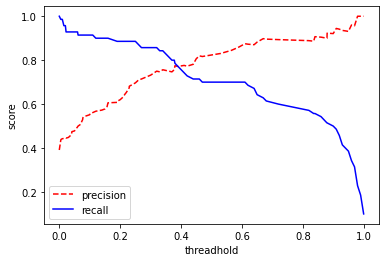

In [64]:
# precision,recall은 trade off관계
precision,recall,th = precision_recall_curve(y_test,proba[:,1])
print(precision[:5],recall[:5],th[:5])
print(len(precision),len(recall),len(th))

 
plt.xlabel('threadhold') #임계값
plt.ylabel('score')
plt.plot(th,precision[:len(th)],'red',linestyle = '--',label = 'precision')
plt.plot(th,recall[:len(th)],'blue',label = 'recall')
plt.legend()
plt.show()

최적의 임계값은 0.3xx. 임계값을 낮추면 정밀도는 낮아지고 재현율은 올라간다. 
임계값을 높이면 정밀도는 올라가고 재현율은 낮아진다. 

[0.39106145 0.43670886 0.43949045 0.44230769 0.44370861] [1.         0.98571429 0.98571429 0.98571429 0.95714286] [2.   1.   0.99 0.98 0.97]
87 87 63


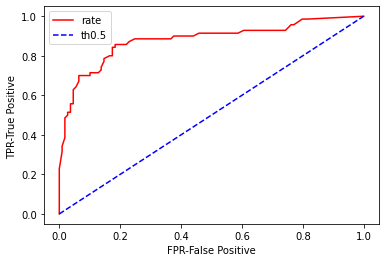

In [65]:
## 연습용 roc_curve( )
fpr,tpr,th = roc_curve(y_test,proba[:,1])
print(precision[:5],recall[:5],th[:5])
print(len(precision),len(recall),len(th))

 
plt.xlabel('FPR-False Positive') 
plt.ylabel('TPR-True Positive ')
plt.plot(fpr,tpr,'red',label = 'rate')
plt.plot([0,1],[0,1],'blue',linestyle = '--',label = 'th0.5')
plt.legend()
plt.show()

### 연습용 : th 조절
-- 점수를 높이기 위해 roc curve까지 확인했다면, 임계치를 조정해보자!

* sklearn Default threadholds > 0.5 ---> 0.5보다 커야 1로 예측

In [74]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 결과 값의 두 번째 컬럼, 
#즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
proba_1 = proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(proba_1)
custom_pred = binarizer.transform(proba_1)

recall=recall_score(y_test, custom_pred)
acc=accuracy_score(y_test, custom_pred)

print(f"재현율:{recall}, 정확도:{acc:.4f}")

재현율:0.7, 정확도:0.8268


In [76]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 
#즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
proba_1 = proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(proba_1)
custom_pred = binarizer.transform(proba_1)

recall=recall_score(y_test, custom_pred)
acc=accuracy_score(y_test, custom_pred)

print(f"재현율:{recall:.4f}, 정확도:{acc:.4f}")

재현율:0.7429, 정확도:0.8156


<수업용 필기>

In [70]:
proba = model.predict_proba(X_test[:10])
print("model.predict_proba() \n", proba)
print(  (proba[:,1]>0.5))
print(  (proba[:,1]>0.5).astype(int))

print(  (proba[:,1]>0.47).astype(int))

model.predict_proba() 
 [[0.03       0.97      ]
 [0.98246429 0.01753571]
 [1.         0.        ]
 [0.04       0.96      ]
 [0.7        0.3       ]
 [0.74       0.26      ]
 [0.15       0.85      ]
 [0.57       0.43      ]
 [0.8        0.2       ]
 [0.35       0.65      ]]
[ True False False  True False False  True False False  True]
[1 0 0 1 0 0 1 0 0 1]
[1 0 0 1 0 0 1 0 0 1]


--- 
<pre>
proba = model.predict_proba(X_test)
<b>proba                        proba[:,1]>0.5    proba[:,1]>0.47</b>
 [[0.         1.        ]    1                 1 
 [0.84162351 0.15837649]     0                 0
 [0.99857143 0.00142857]     0                 0
 [0.1        0.9       ]     1                 1
 <font color=red>
 [0.5105     0.4895    ]     0                 1
 [0.51       0.49      ]     0                 1
 </font>
 [0.136      0.864     ]     1                 1
 [0.69333333 0.30666667]     0                 0
 [0.86088074 0.13911926]     0                 0
 [0.09752778 0.90247222]]    1                 1
</pre>
---

In [71]:
roc_df = pd.DataFrame(
    {
    'FPR'  : fpr, 
    'TPR'  : tpr, 
    'TH'   : th,
    'DIFF' : tpr - fpr}
)
print(roc_df.tail())
                  
roc_df[roc_df['DIFF'] == roc_df['DIFF'].max()]

         FPR       TPR        TH      DIFF
63  0.770642  0.971429  0.020000  0.200786
64  0.788991  0.971429  0.017536  0.182438
65  0.807339  0.985714  0.010000  0.178375
66  0.834862  0.985714  0.002500  0.150852
67  1.000000  1.000000  0.000000  0.000000


,FPR,TPR,TH,DIFF
39,0.201835,0.871429,0.31,0.669594


In [72]:
# opt_th = 0.4383333333333333
opt_th = roc_df[roc_df['DIFF'] == roc_df['DIFF'].max()]['TH'].values[0]

print(opt_th)

proba = model.predict_proba(X_test)
print(proba[1:6])
pred = model.predict(X_test)
print(pred[1:6])
# -----------------------------------
re_proba = proba[:,1] >= opt_th   #  > 0.438333
print(re_proba[1:6].astype(int))

0.31
[[0.98246429 0.01753571]
 [1.         0.        ]
 [0.04       0.96      ]
 [0.7        0.3       ]
 [0.74       0.26      ]]
[0 0 1 0 0]
[0 0 1 0 0]


### 임계치 조정 후 점수 확인

In [74]:
proba = model.predict_proba(X_test)
my_fun(y_test, pred)
print("--" * 30)

re_proba = proba[:,1] >= opt_th   #  > 0.438333
my_fun(y_test, re_proba)


              precision    recall  f1-score   support

           0       0.84      0.91      0.87       109
           1       0.84      0.73      0.78        70

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

정확도 0.8380 정밀도 0.8375 재현률 0.8184 f1 0.8254
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       109
           1       0.73      0.87      0.80        70

    accuracy                           0.83       179
   macro avg       0.82      0.83      0.82       179
weighted avg       0.84      0.83      0.83       179

정확도 0.8268 정밀도 0.8206 재현률 0.8348 f1 0.8231


<pre>
RandomForestClassifier정확도 : 0.810056
LogisticRegression정확도 : 0.821229
KNeighborsClassifier정확도 : 0.709497
DecisionTreeClassifier정확도 : 0.793296
LinearSVC정확도 : 0.759777
-----------------------------------------------평균나이 , Name_title
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8492
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7989
LinearSVC 		 정확도:0.7430
----------------------------------------------- alone family 파생변수 추가
RandomForestClassifier 		 정확도:0.8268
LogisticRegression 		 정확도:0.8324
KNeighborsClassifier 		 정확도:0.7263
DecisionTreeClassifier 		 정확도:0.7933
LinearSVC 		 정확도:0.8101
RandomForestClassifier정확도 : 0.81005
----------------------------------------------- family 파생변수 추가
RandomForestClassifier 		 정확도:0.8324
LogisticRegression 		 정확도:0.8380
KNeighborsClassifier 		 정확도:0.7207
DecisionTreeClassifier 		 정확도:0.8045
LinearSVC 		 정확도:0.6201
----------------------------------------------- family 파생변수 추가, 요금구간화
RandomForestClassifier 		 정확도:0.8380
LogisticRegression 		 정확도:0.8212
KNeighborsClassifier 		 정확도:0.7933
DecisionTreeClassifier 		 정확도:0.7821
LinearSVC 		 정확도:0.8101
-----------------------------------------------  Fare , family, Age 구간화
RandomForestClassifier 		 정확도:0.8492
LogisticRegression 		 정확도:0.8324
KNeighborsClassifier 		 정확도:0.8101
DecisionTreeClassifier 		 정확도:0.8156
LinearSVC 		 정확도:0.8324


### 모델튜닝 & 검증

In [59]:
## 가공, 모델, 데이터 증강
## 모델튜닝 ... 도구